In [1]:
# Fill in your name using the format below and student ID number
your_name = "van Gastel, Rob"
student_id = "1387952"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
!pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Rob, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [8]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [10]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [11]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [12]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

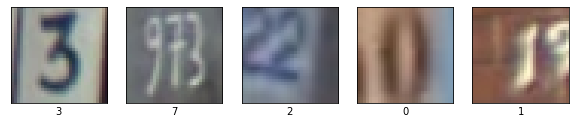

In [13]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
        return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
        return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

In [15]:
from tensorflow.keras import regularizers, optimizers, models, layers

def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(10, activation='softmax'))
    # adag = optimizers.Adagrad(lr=0.01) or
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=False, epochs=45, batch_size=32)

answer_q_1_1 = """
I slowly increased the size and amount of layers within reasonable range until 
no improvements based on score were gained. Also, different optimization methods 
were tested Adagrad and SGD gave the best results. As activation function 
Leaky ReLu was used, as this performed better and prevents the 'dead neuron' 
problem of ReLu. The score obtained on validation is 85%, but we can still 
see a large deviation between the validation and training accuracy in the plot.
"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

Loading model from file
Answer is 472 characters long


### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [16]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

In [17]:
from tensorflow.keras import optimizers

# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dense(10, activation='softmax'))
    # adag = optimizers.Adagrad(lr=0.1) # or
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=45, batch_size=32)

answer_q_1_2 = """
Preprocessing the images creates less input parameters, namely the colour channels. 
Which don't seem to be necessary for classification of the numbers. Removing these 
dimensions by the greyscale conversion makes for less input parameters making the 
model less complex. Also, reduce in size of the training data reduces the 
computational cost of the model. These are improvements on the model. As it has
approximately the same score as model 1.1.
"""
print("Answer is {} characters long".format(len(answer_q_1_2)))

Loading model from file
Answer is 451 characters long


### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

In [18]:
def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='softmax'))
    # adag = optimizers.Adagrad(lr=0.1) # or
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=45, batch_size=64)

# The article used to support picking low dropout rates,
# https://www.sciencedirect.com/science/article/pii/S0012825219305549

answer_q_1_3 = """I observed batch normalization has a lot of impact as the model converged quicker.
When applying Bias, Kernel, activity -regularization the model converged slower or
not at all. Using Dropout layers had a lot of effect on the difference between
training and validation score. Dropout performed better with a higher learning
rate of 0.01, a dropout rate of 0.1, a batch size of 64 and 45 epochs. About 2%
accuracy score is gained on the validation set, but the model still overfits the training data.
"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

Loading model from file
Answer is 500 characters long


## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

In [19]:
def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))    
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))    
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(10, activation='softmax'))
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=30, batch_size=64)

answer_q_2_1 = """
I retained the same activation functions as in Q1, as this performed better than
ReLu, TanH and sigmoid. I slowly expanded on different layers structures of
convolutional layers. Applying at least 2 convolutional layers followed by max
pooling, like the VGG model, led to an increase in accuracy. These convolutional
layers are followed by 2 dense layers. Using regular ReLu on the convolutional layers, improved
the model. After this batch normalization and dropout layers were applied as regularization. 
Based on testing different architectures I mobtained current model. This resulted in the model converging faster and a closer
training and validation score. The model performs about 10% better than the models of Q1, with 95% accuracy.
"""
print("Answer is {} characters long".format(len(answer_q_2_1)))

Loading model from file
Answer is 743 characters long


### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

In [20]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
)
train_data_gen.fit(preprocessed_split[0])
it_gen = train_data_gen.flow(x=preprocessed_split[0], y=preprocessed_split[2], batch_size=64)

steps = int(X_train.shape[0] / 64)
augmented_split = it_gen, preprocessed_split[1], preprocessed_split[3]
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, steps_per_epoch=steps,
               train=False, epochs=70, batch_size=None, generator=True)

answer_q_2_2 = """
If the model performed well on the training (while using the augmented data)
the validation score would usually be higher than the training score and converge
faster. Techniques that didn't perform well, brightness, large zooms and vertical
/horizontal flips. Techniques that perform well, small rotations (30 degrees),
applying a shear, a small zoom and width/height shifting. The most benefit was
observed when combining the techniques. We gain about 0.5% accuracy compared to
model 2.1.
"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

Loading model from file
Answer is 491 characters long


## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

19858/19858 - 5s - loss: 0.1621 - accuracy: 0.9555
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_46 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
co

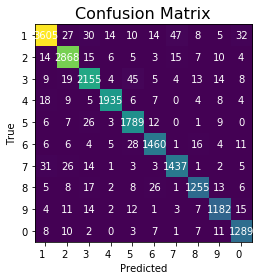

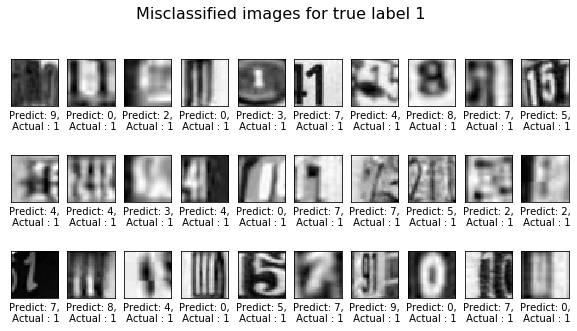

Answer is 671 characters long


In [21]:
from sklearn.metrics import confusion_matrix

# Store the test score of model 2.2
model = load_model_from_file(base_dir, "model_2_2")
_, test_acc = model.evaluate(rgb2gray(X_test), y_test, verbose=2)
model.summary()

# Set test score
test_accuracy_3_1 = test_acc
print("Accuracy score of model 2_2 on the test set: ", test_acc)

# Create the prediction labels of model 2.2 on the test set
y_pred = model.predict(rgb2gray(X_test))
X_test_t = rgb2gray(X_test)

def plot_confusion_matrix():
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots()
    plt.title("Confusion Matrix", fontsize=16)
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 0], ha="right")
    ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

def plot_misclassifications():
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
    
    # missclassifying happens often for class 1
    labels_five = [i for i, item in enumerate(y_test) if np.argmax(item) == 0]
    cases = np.intersect1d(labels_five, misclassified_samples)
    
    fig, ax = plt.subplots(3, 10, figsize=(10, 5))
    fig.suptitle('Misclassified images for true label 1', fontsize=16)
    j = -1;
    for i, sample in enumerate(cases[:30]):
        if i % 10 == 0:
            j += 1
        i = i % 10
        ax[j][i].imshow(X_test_t[sample].reshape(32, 32), cmap="gray")
        ax[j][i].set_xlabel("Predict: %s,\n Actual : %s" % ((np.argmax(y_pred[sample])+1)%10, 
                                                          ((np.argmax(y_test[sample])+1)%10)))
        ax[j][i].set_xticks(()), ax[j][i].set_yticks(())
    plt.show()

plot_confusion_matrix()
plot_misclassifications()

answer_q_3_1 = """
An accuracy score of 95.6% is obtained on the test data. The class that has the most miss classifications
is label 1. With most cases misclassifying it for 0 and 7. Most of these false predictions are
categorized as label 1. Looking at the mistakes made in the misclassifications plot for label 1. 
Mistakes that are observed in this plot are, images wrongly labelled were the actual label doesn't
correspond to the y label e.g. mistake in the dataset, images with a lot of noise such as blurry
pictures and other symbols in the same picture and images with multiple numbers in the image 
where predicting one of the other numbers in the image is a miss classification.
"""
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

C:\Users\robva\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


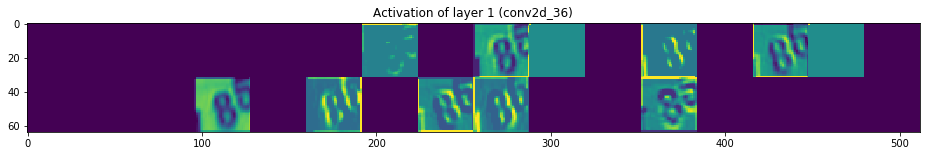

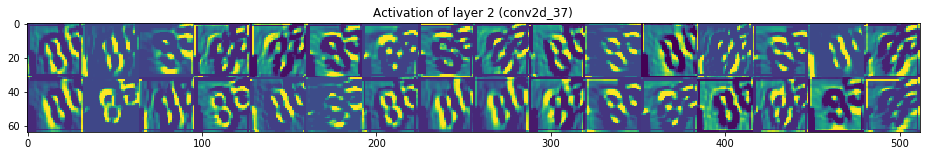

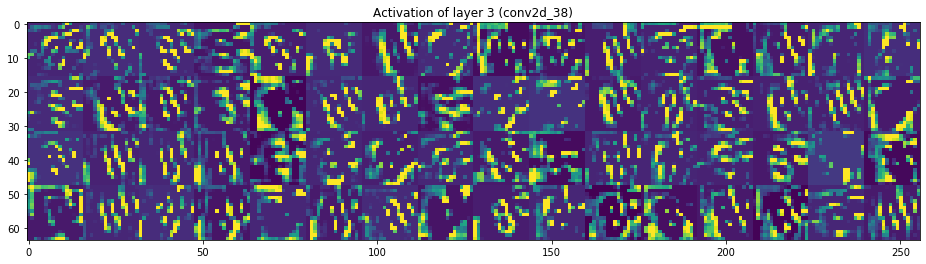

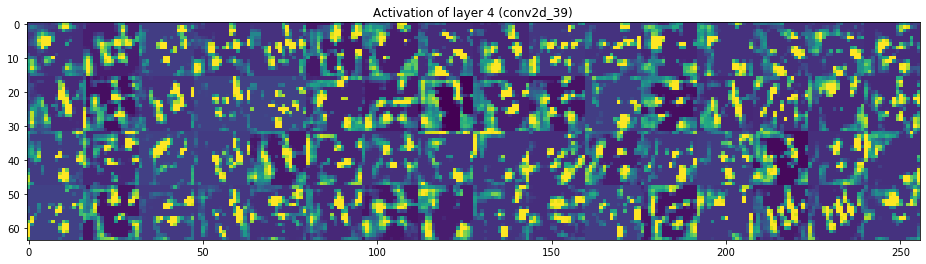

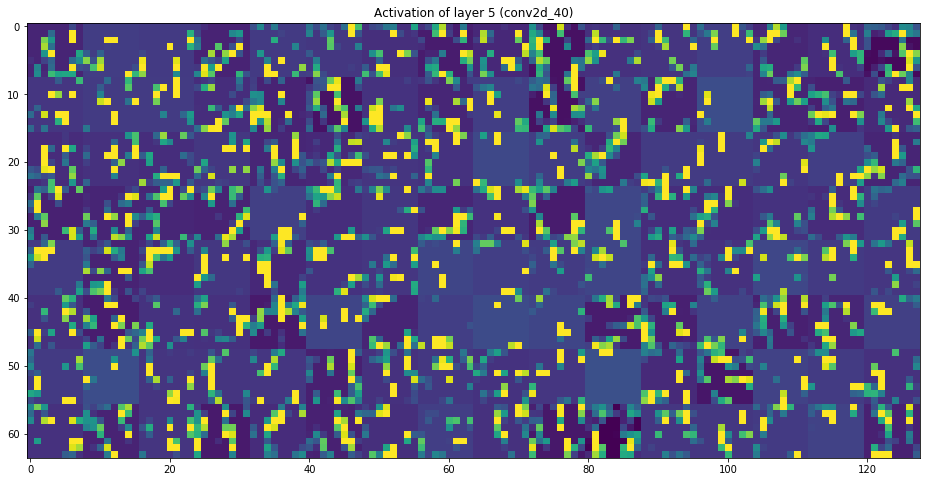

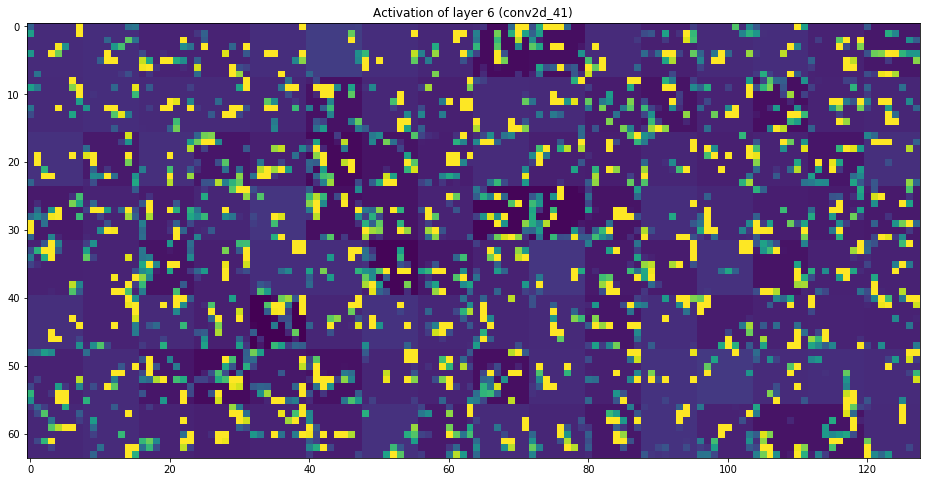

Answer is 582 characters long


In [22]:
from tensorflow.keras import models

def plot_activations():
    # Example as seen in the slides about CNN
    
    x_sample, y_sample = X_test[0], y_test[0]
    sample = np.expand_dims(x_sample, axis=0)
    sample = rgb2gray(sample)
    
    model = load_model_from_file(base_dir, "model_2_2")
    
    # All convolutional layers
    layers = [model.layers[0], model.layers[2], model.layers[6], model.layers[8], model.layers[12], model.layers[14]]
    layer_outputs = [layer.output for layer in layers]
    layer_names = [layer.name for layer in layers]
    
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(sample)
    
    images_per_row = 16
    
    # For all convolutional layers
    for i in range(0, len(layers)):
        start = i
        end = i+1
        layer_index = i
        for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]

            n_cols = n_features // images_per_row
            display_grid = np.zeros((size * n_cols, images_per_row * size))

            for col in range(n_cols):
                for row in range(images_per_row):
                    channel_image = layer_activation[0,
                                                     :, :,
                                                     col * images_per_row + row]
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                    display_grid[col * size : (col + 1) * size,
                                 row * size : (row + 1) * size] = channel_image

            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1],
                                scale * display_grid.shape[0]))
            plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()
    
plot_activations()
    
answer_q_3_2 = """
In the first layer we see a lot of purple parts which dont seem to activate the 8 and 5.
In the second layer we can see more clearly that in most cases the contour of 8 is
highlighted. Especially the second layer we see most images being yellow colored for 8.
The layers 3 and 4 seem to highlight certain patterns within the image like vertical
edges. The deeper we go into the layers the lower the resolution gets and abstracter
the patterns become. In the laste 2 layers it becomes hard to see by the human eye 
which features the convolutional layers use to classify the image.
"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


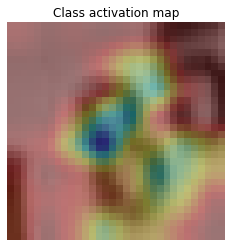

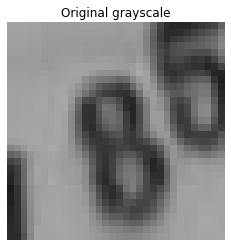

In [23]:
from tensorflow.keras import backend as K
import matplotlib.image as mpimg
import cv2

def plot_activation_map():
    # Example as seen in the slides about CNN
    K.clear_session()
    tf.compat.v1.disable_eager_execution()
    
    x_sample, y_sample = X_test[0], y_test[0]
    x_sample = rgb2gray(np.expand_dims(x_sample, axis=0))

    model = load_model_from_file(base_dir, "model_2_2")
    preds = model.predict(x_sample)
    
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    
    last_conv_layer  = model.get_layer("conv2d_41")
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x_sample])
    
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
        
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    image = np.concatenate((x_sample[0], x_sample[0], x_sample[0]), axis=2)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Show superimposed image
    superimposed_img = heatmap * 0.3 + image * 255 * 0.7
    plt.imshow(superimposed_img.astype(np.uint8), vmax=255, vmin=0)
    plt.axis('off')
    plt.title('Class activation map')
    plt.show()
    
    # original grayscale image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title('Original grayscale')
    plt.show()

def plot_3_3():
    plot_activation_map()

plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

In [24]:
# Test layer structure
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import VGG16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for i in range(0, len(vgg.layers)-4):
    vgg.layers[i].trainable = False
    print(vgg.layers[i].name)

vgg.summary()

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

def build_model_4_1():
    model = models.Sequential()
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    for i in range(0, len(base_model.layers)-8):
        base_model.layers[i].trainable = False
    model.add(base_model)
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Using the same image augmentation generator
train_data_gen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
)
train_data_gen.fit(evaluation_split[0])
it_gen = train_data_gen.flow(x=evaluation_split[0], y=evaluation_split[2], batch_size=64)

steps = int(X_train.shape[0] / 64)
eval_split = it_gen, evaluation_split[1], evaluation_split[3]
run_evaluation("model_4_1", build_model_4_1, eval_split, base_dir, steps_per_epoch=steps,
               train=False, epochs=40, batch_size=None, generator=True)

# Training without augmented data
# run_evaluation("model_4_1", build_model_4_1, eval_split, base_dir, 
#                train=True, epochs=40, batch_size=64)

# Remarks
# Using the previous improved SGD resulted in a saved model which was too large
# thus the default SGD has been used instead.
answer_q_4_1 = """
Using the VGG16 as base model, a lot of different observations were made.Training
the model without unfreezing any or few layers resulted in a low accuracy score.
Iteratively unlocking more layers the accuracy score went up.As the model should be
fine-tuned on the data a smaller learning rate of 1e-4 is picked, such that the original
information of the layers is not destroyed. The best result was obtained freezing the first
8 layers with a validation accuracy score of 93% using augmentation.
"""
print("Answer is {} characters long".format(len(answer_q_4_1)))

Loading model from file
Answer is 498 characters long


### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [26]:
import pickle
import gzip

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    model_name = "model_4_1"
    model = load_model_from_file(base_dir, model_name).layers[0]
    names = ["train", "val", "test"]
    X_set = [X_train, X_val, X_test]
    
    for i, X_s in enumerate(X_set):
        name = f"model_4_1_{names[i]}"
        output = model.predict(X_s)
        store_embedding(output, name)
    
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
    evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    # Assumption that both accuracy scores need to be returned
    pipeline = pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    return test_score

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    # Assumption that the training embeddings are not reshaped when
    # passed.
    model_name = "model_4_1"
    model = load_model_from_file(base_dir, model_name).layers[0]
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)
    
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    pipeline = generate_pipeline().fit(X_train, y_train)
    
    # Only pass the test score
    # train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    return test_score

# TODO: Uncomment if embeddings need to be created
# If no embeddings are store run store_embeddings
# store_embeddings()

# Create the sets
X_train_emb = load_embedding("model_4_1_train")
X_test_emb = load_embedding("model_4_1_test")
X_val_emb = load_embedding("model_4_1_val")

y_train_emb = np.argmax(y_train, axis=1)
y_test_emb = np.argmax(y_test, axis=1)
y_val_emb = np.argmax(y_val, axis=1)

# For model selection
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_val_emb, y_val_emb, stratify=y_val_emb, 
                                                        train_size=0.8, test_size=0.2, random_state=1)

X_train_emb.shape, X_test_emb.shape, X_val_emb.shape

((63544, 1, 1, 512), (19858, 1, 1, 512), (15887, 1, 1, 512))

In [27]:
# Attempt boosting/bagging
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# Log Regression as seen in first week
from sklearn.linear_model import LogisticRegression
# SVM performs well on many features
from sklearn.svm import SVC
# The classes should be similar to eachother so
# kNN could perform well
from sklearn.neighbors import KNeighborsClassifier

# Reduce the feature space, as the sklearn algorithms
# would take too long to run without.
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer

import seaborn as sns


# Helper to visualize gridsearch
def heatmap(columns, rows, scores):
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")

# If the gridspace is small use the heatmap
# scores = grid.cv_results_['mean_test_score'].reshape(2, -1)
# heatmap(param_grid['clf__n_estimators'], 
#         param_grid['clf__max_features'],
#         scores)

# Transforms embedding to shape (n, 3072)
def transform_embedding(X):
    shape = X.shape[1:len(X)-1]
    return np.reshape(X, (len(X), np.prod(shape)))

# def generate_pipeline():
#     """ Returns an sklearn pipeline.
#     """
#     transformer = FunctionTransformer(transform_embedding)
#     clf = RandomForestClassifier()
#     return Pipeline(steps=[('reshape', transformer), 
#                            ('reduce_dim', PCA()), 
#                            ('clf', clf)])

# Do the gridsearch
# Commented as this takes too long for the verify.py
# Best accuracy score obtained, 0.93

# pipe = generate_pipeline()
# param_grid = {'reduce_dim__n_components':[0.9, 0.95, 0.98],
#               'clf__n_estimators': [100, 250, 500]}
# grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(Xe_train, ye_train)

# clf = grid.best_estimator_
# ye_pred = clf.predict(Xe_test)
# print(classification_report(ye_test, ye_pred))

In [28]:
# AdaBoostClassifier with PCA
# def generate_pipeline():
#     """ Returns an sklearn pipeline.
#     """
#     transformer = FunctionTransformer(transform_embedding)
#     clf = AdaBoostClassifier()
#     return Pipeline(steps=[('reshape', transformer),
#                            ('reduce_dim', PCA()), 
#                            ('clf', clf)])

# Do the gridsearch
# Commented as this takes too long for the verify.py
# Best accuracy score obtained, 0.78

# pipe = generate_pipeline()
# param_grid = {'reduce_dim__n_components':[0.9, 0.95, 0.98],
#               'clf__n_estimators': [100, 250, 500],
#               'clf__learning_rate': [1, 1.5, 2]}
# grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(Xe_train, ye_train)

# clf = grid.best_estimator_
# ye_pred = clf.predict(Xe_test)
# print(classification_report(ye_test, ye_pred))

In [29]:
# LogisticRegression with PCA
# def generate_pipeline():
#     """ Returns an sklearn pipeline.
#     """
#     transformer = FunctionTransformer(transform_embedding)
#     clf = LogisticRegression()
#     return Pipeline(steps=[('reshape', transformer),
#                            ('reduce_dim', PCA()),
#                            ('clf', clf)])

# Do the gridsearch
# Commented as this takes too long for the verify.py
# Best accuracy score obtained, 0.93 

# pipe = generate_pipeline()
# param_grid = {'reduce_dim__n_components':[0.9, 0.95, 0.98],
#               'clf__C': np.logspace(-12, 12, num=22)}
# grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(Xe_train, ye_train)

# clf = grid.best_estimator_
# ye_pred = clf.predict(Xe_test)
# print(classification_report(ye_test, ye_pred))

Boosting, bagging and logistic regression didn't look very promissing decided to consult literature. This paper (https://arxiv.org/pdf/1805.02294.pdf) suggests using SVM and kNN as algorithms.

In [30]:
# kNN with PCA
# def generate_pipeline():
#     """ Returns an sklearn pipeline.
#     """
#     transformer = FunctionTransformer(transform_embedding)
#     clf = KNeighborsClassifier()
#     return Pipeline(steps=[('reshape', transformer),
#                            ('reduce_dim', PCA()),
#                            ('clf', clf)])

# Do the gridsearch
# Commented as this takes too long for the verify.py
# Best accuracy score obtained, 0.93

# pipe = generate_pipeline()
# param_grid = {'reduce_dim__n_components':[0.9, 0.95, 0.98],
#               'clf__n_neighbors': np.geomspace(1, (len(Xe_train))**(1/2), num=5, dtype=int)[1:]}
# grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(Xe_train, ye_train)

# # The best score obtained with kNN was 0.43 lower than expected and as
# # mentioned in the paper. 
# clf = grid.best_estimator_
# ye_pred = clf.predict(Xe_test)
# print(classification_report(ye_test, ye_pred))

In [31]:
# SVC with PCA
# def generate_pipeline():
#     """ Returns an sklearn pipeline.
#     """
#     transformer = FunctionTransformer(transform_embedding)
#     clf = SVC()
#     return Pipeline(steps=[('reshape', transformer),
#                            ('reduce_dim', PCA(n_components=0.98)), 
#                            ('clf', clf)])

# Do the gridsearch
# Commented as this takes too long for the verify.py
# Best accuracy score obtained, 0.93

# 'reduce_dim__n_components':[0,9, 0.95, 0.98] taken the explained percentage of from
# the embeddings fixed to 0.98 as it performed better.

# pipe = generate_pipeline()
# param_grid = {'clf__C': np.logspace(-12, 12, num=10),
#               'clf__gamma': np.logspace(-12, 12, num=10, base=2), }
# grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1).fit(Xe_train, ye_train)

# scores = grid.cv_results_['mean_test_score'].reshape(10, -1)
# heatmap(param_grid['clf__gamma'], 
#         param_grid['clf__C'],
#         scores)

# clf = grid.best_estimator_
# ye_pred = clf.predict(Xe_test)
# print(classification_report(ye_test, ye_pred))

In [34]:
# The final generator pipeline with the best performing estimator
def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    # TODO: Adjust to best classifier
    transformer = FunctionTransformer(transform_embedding)
    clf = SVC(C=4.64158883e-02, gamma=2.44140625e-04)
    
    return Pipeline(steps=[('reshape', transformer),
                           ('reduce_dim', PCA(n_components=0.98)), 
                           ('clf', clf)])

# evaluation_4_2(X_train, y_train, X_test, y_test)

In [33]:
# I was very confused with the implementation of evaluate_pipeline and evaluate_4_2
# how the dataset should be passed on to the method. Also I decided to comment the model
# selection and other methods to preserve running time.

# This paper (https://arxiv.org/pdf/1805.02294.pdf) suggests using SVM and kNN as algorithms.
answer_q_4_2 = """
The algorithms attempted to are logistic regression, SVM, Adaboost and RandomForest. PCA was used
to reduce size of the embeddings and running times. Grid search was used to find good parameters.
Algorithms suggested by the paper (linked in the notebook) SVM and kNN, performed
well during model selection. The best score obtained on model selection was 93% accuracy and 92%
on the test set, by SVM. This is the same score as model_4_1. I wasnt able to beat most scores
of previous models.
"""

print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Pipeline: Pipeline(memory=None,
         steps=[('reshape',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function transform_embedding at 0x0000011762C2C9D8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=0.98,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=0.0464158883, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma=0.000244140625, kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         v